# Оптимизация гиперпараметров модели

## 1. Введение

Цели модуля:
* Узнать, какие есть базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV);
* Узнать, какие есть продвинутые способами оптимизации (Hyperopt, Optuna);
* Научиться их настраивать и обучать модели с их использованием,  так, чтобы улучшать итоговую метрику.  
* Провести сравнение и понять преимущества и недостатки каждого из методов


## 2. Базовая оптимизация

В базовой оптимизации, предоставляемой библиотекой sklearn, есть два основных метода — grid search и random search**. С ними мы сейчас и познакомимся. Оба используются при решении реальных задач, поэтому важно разобраться, как они устроены. 

Наиболее часто используемый метод — это **поиск по сетке** (grid search), который по сути является попыткой перебрать все возможные комбинации заданных гиперпараметров. Мы указываем список значений для различных гиперпараметров, и, ориентируясь на нашу метрику, оцениваем эффективность модели для каждого их сочетания, чтобы получить оптимальную комбинацию значений.

Допустим, мы хотим подобрать гиперпараметры min_samples_leaf и max_depth для алгоритма DecisionTreeClassifier. Зададим списки их значений:

In [47]:
min_samples_leaf = [3, 5, 8, 9]
max_depth = [4, 5, 6, 7, 8]

Поскольку нам нужно перебрать четыре различных значения для min_samples_leaf и пять — для max_depth, то получается всего 4*5=20 комбинаций. Модель будет обучена 20 раз; столько же раз будет рассчитана метрика.

*Сколько раз придется обучить модель, если мы хотим подобрать гиперпараметры min_samples_leaf, max_depth, criterion со следующими списками значений:*

In [48]:
min_samples_leaf = [7, 8, 9]
max_depth = [2, 7, 8, 10]
criterion = ['gini', 'entropy']

Получается всего 3*4*2=24 комбинации. Модель будет обучена 24 раза; столько же раз будет рассчитана метрика.

## ОПАСНОСТЬ ПЕРЕОБУЧЕНИЯ И УТЕЧКИ ДАННЫХ

Для того, чтобы выбрать оптимальные значения гиперпараметров, мы ориентируемся на выбранную метрику, рассчитанную на тестовой выборке. Мы делали это для подбора гиперпараметра регуляризации alpha, но является ли это надёжным подходом?

Давайте вспомним: мы перебираем множество значений гиперпараметров и выбираем ту комбинацию значений, которая даёт наилучшую точность на тестовых данных. Однако это **совсем не означает, что на новых данных мы получим такой же результат**. 

Поскольку мы использовали тестовый набор для настройки гиперпараметров, мы больше не можем использовать его для оценки качества модели. Теперь в этих целях нам необходим независимый набор данных, то есть набор, который не использовался для построения модели и настройки её гиперпараметров.

Следовательно, надо разбить данные на **три части: обучающую** для построения модели, проверочную (**валидационную**) для выбора гиперпараметров модели, а также **тестовую** для оценки качества модели и выбранных гиперпараметров. 

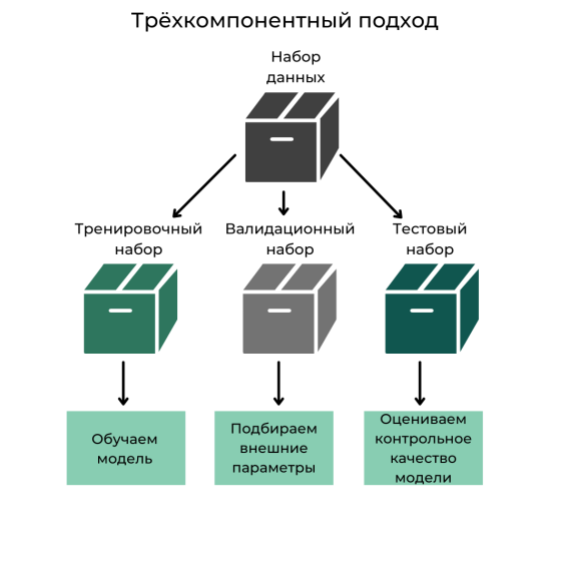

Наличие всех трёх наборов данных критически важно для использования МО. Любой подбор гиперпараметров, сделанный на тестовых данных, «сливает» модели информацию, содержащуюся в них, и может привести к неправильной оценке качества модели. Такая проблема относится к категории утечки данных.

Рассмотренный метод разбиения данных на обучающий, проверочный и тестовый наборы является вполне рабочим и относительно широко используемым, но весьма чувствителен к равномерности разбиения данных. 

Для лучшей оценки обобщающей способности вместо одного разбиения данных на обучающий и проверочный наборы мы можем воспользоваться перекрёстной проверкой, то есть **кросс-валидацией** (cross validation). В таком случае качество модели оценивается для каждой комбинации гиперпараметров по всем разбиениям кросс-валидации. 

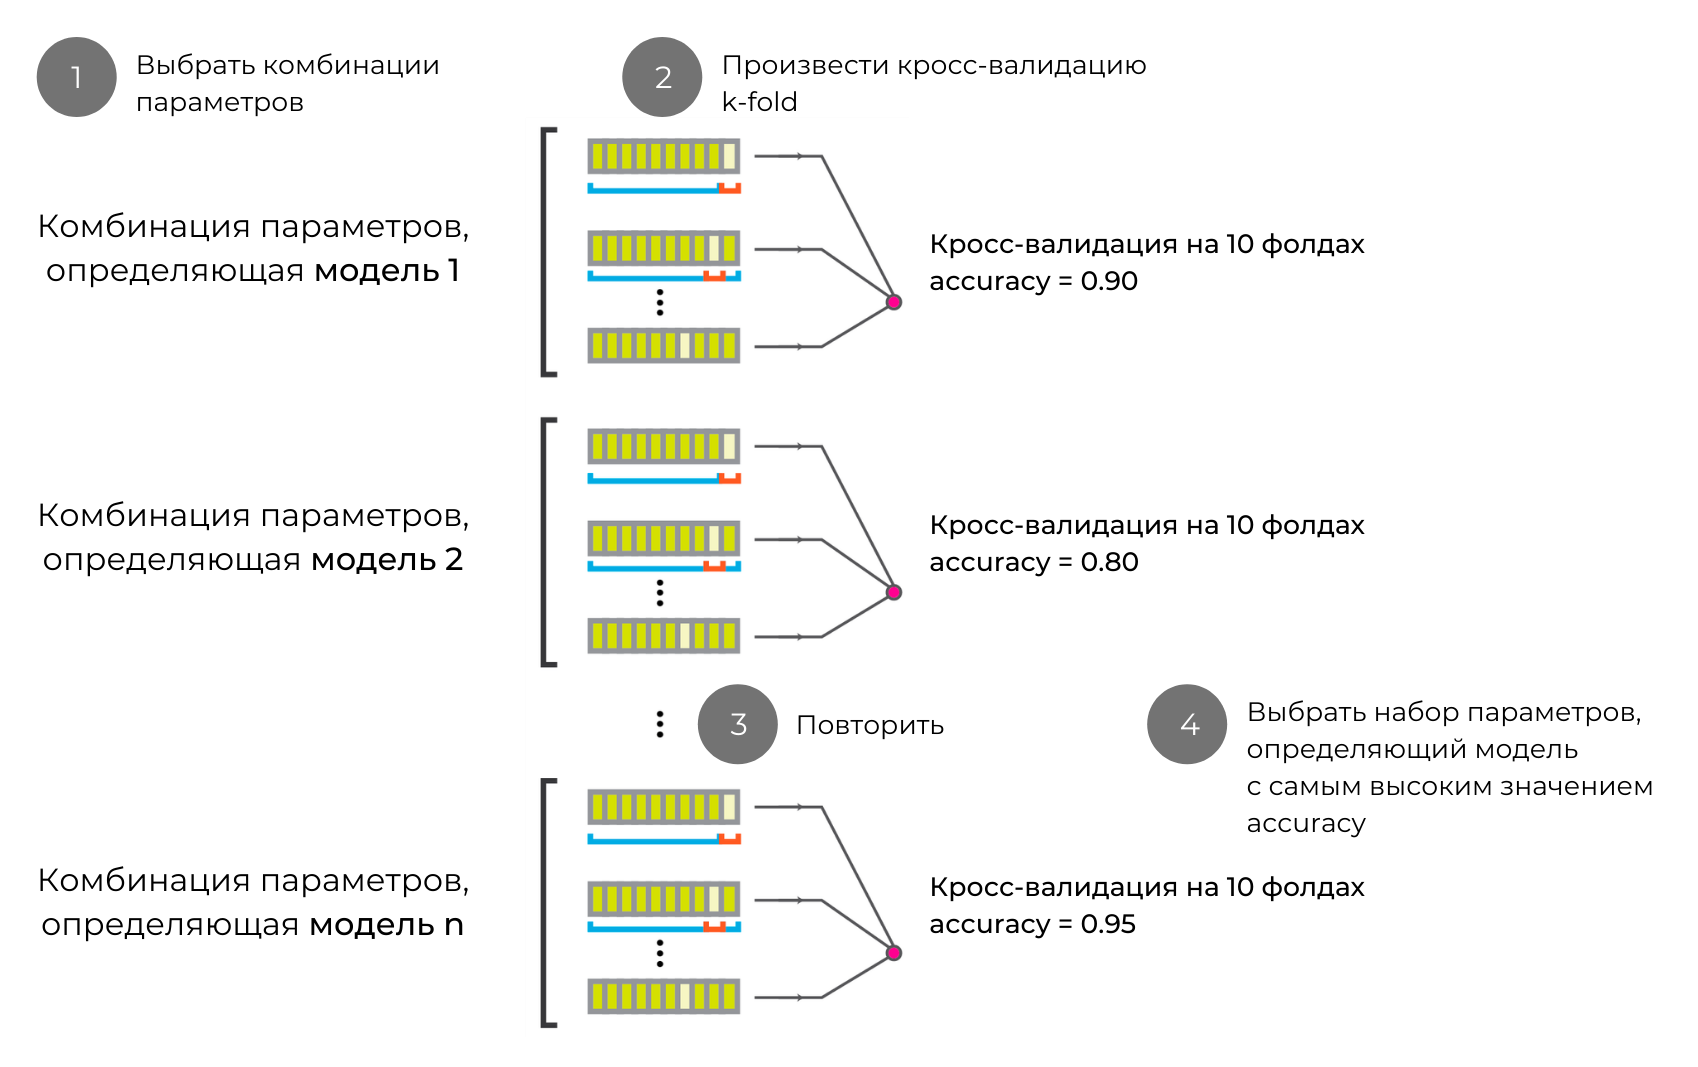

Пояснение к рисунку. Предположим, что у нас есть n комбинаций гиперпараметров. Берём первую комбинацию и обучаем на них первую модель с помощью кросс-валидации с 10 фолдами (cv=10), затем рассчитываем метрику как среднее по всем разбиениям. Так проделываем для каждой комбинации и выбираем ту, при которой наша метрика наилучшая. В итоге мы обучим n*cv моделей, но выберем один набор гиперпараметров, который и будет использоваться для обучения итоговой модели на всей обучающей выборке.

In [49]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

C:\Users\Lida\AppData\Local\Temp\ipykernel_15908\2150022218.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Описание задачи

Продолжим решать задачу кассификации "Предсказание категории дохода человека"

Данные, с которыми мы будем работать были извлечены из базы данных **Бюро переписи населения 1994 года** Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной - предсказание дохода.

Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50K $.


### Знакомство с данными и их исследование

In [50]:
#ЕСЛИ РАБОТАЕМ В IDE
data = pd.read_csv('data/adult.zip')

#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
# from google.colab import drive
# drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
# data = pd.read_csv('./drive/MyDrive/SF/SF module 7/adult.zip')
data.head(3)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

Проверяем наличие пропусков

In [51]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [52]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Смотрим на сбалансированность классов:

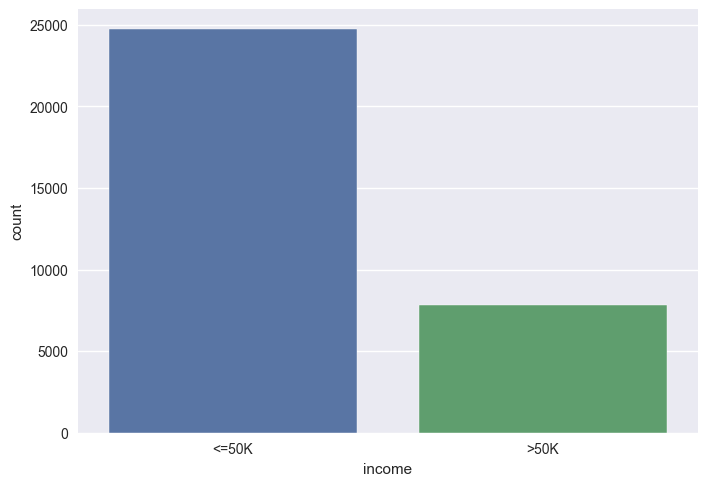

In [53]:
sns.countplot(data=data, x='income');

Для удобства переобозначим целевой признак (не обязательный шаг)

In [54]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [55]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

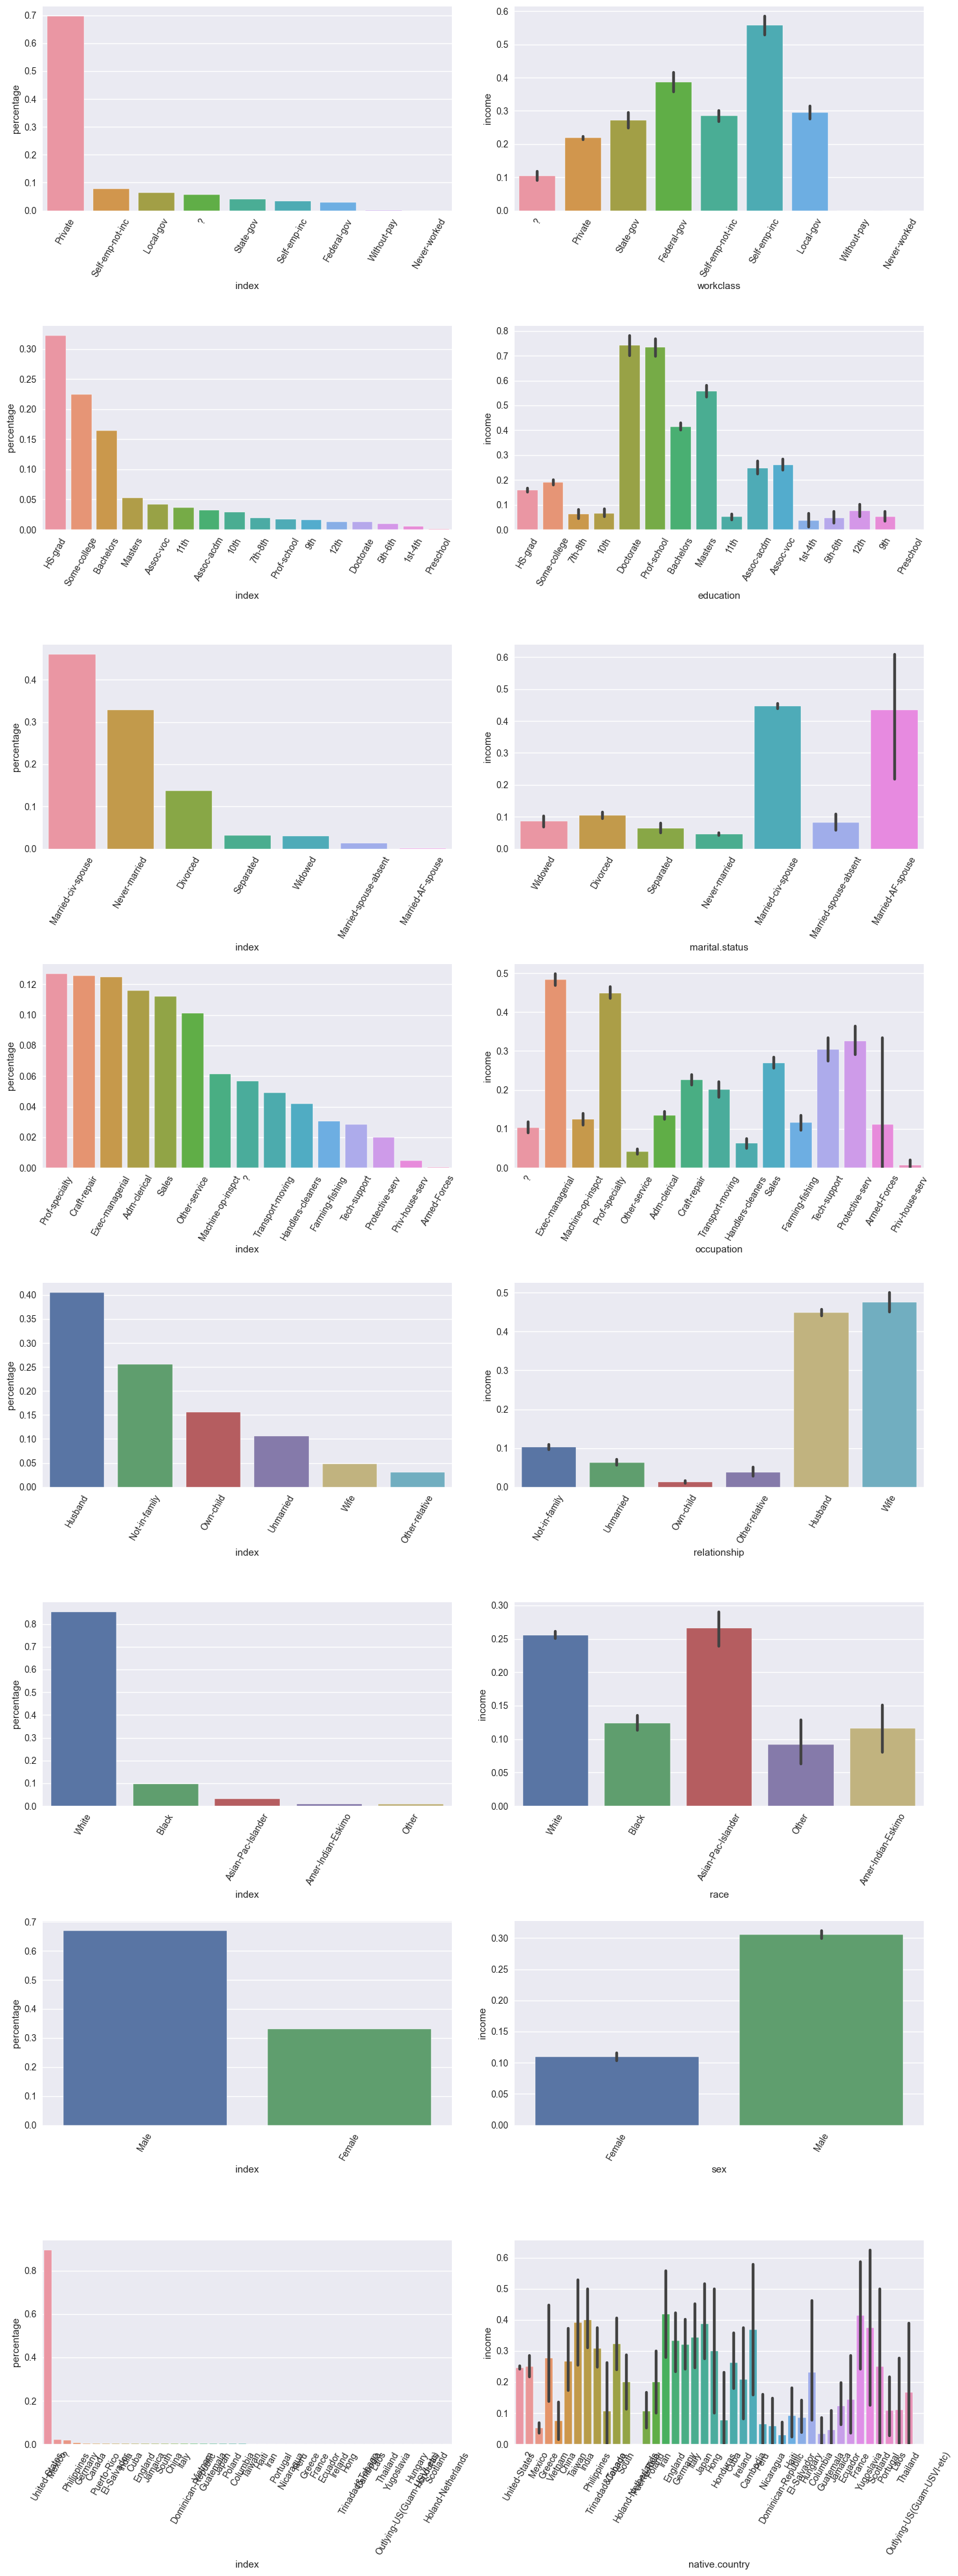

In [56]:
n = len(cat_features) # число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # фигура+n*2 координатных плоскостей
# Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    # Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    # Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() # выравнивание графиков

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [57]:
adult_data = data.copy()
# Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
# Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
# Объединяем вдовцов, разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
# Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
# Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

# Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
# Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [58]:
# Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain'] + 1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss'] + 1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt'] + 1)

# Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [59]:
# Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Проверяем результаты предобработки

In [60]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

C:\Users\Lida\AppData\Local\Temp\ipykernel_15908\3504497888.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(adult_data.corr(), annot = True)


<Axes: >

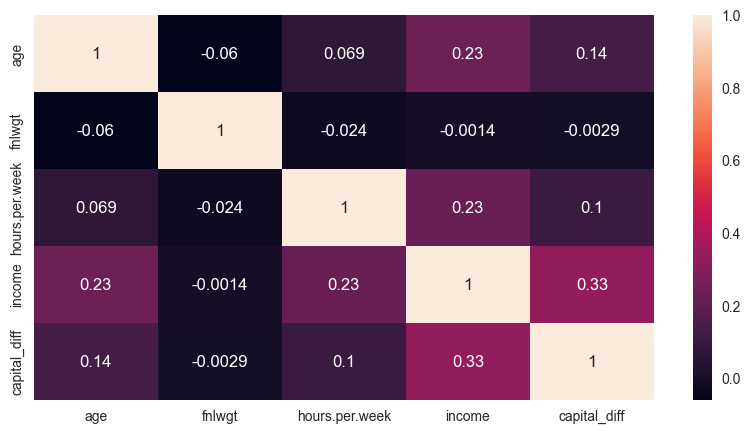

In [61]:
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.corr(), annot = True)

Кодируем текстовые категориальные признаки

In [62]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head(3)

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [63]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [65]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [66]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print(f'accuracy на тестовом наборе: {log_reg.score(X_test_scaled, y_test):.2f}')
y_test_pred = log_reg.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64


А теперь попробуем подобрать оптимальные параметры с помощью поиска по сетке. 

### <center> **GridSearchCV**

Чтобы воспользоваться классом GridSearchCV:
- сначала необходимо импортировать библиотеку; 

In [67]:
from sklearn.model_selection import GridSearchCV

- затем указать искомые гиперпараметры в виде словаря: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров;

Важно помнить, что выбор алгоритма оптимизации зависит от выбранного типа штрафа:

![image.png](attachment:image.png)

In [68]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
                  'solver': ['lbfgs', 'saga'] #алгоритм оптимизации
                  }

- после передаем модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, (допустим, пятиблочную кросс-валидацию, cv=5) и n_jobs = -1, чтобы использовать все доступные ядра для расчетов.

In [69]:
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=1, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

Созданный нами объект grid_search аналогичен классификатору, мы можем вызвать стандартные методы fit, predict и score от его имени. Однако, когда мы вызываем fit, он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid.

In [70]:
grid_search.fit(X_train_scaled, y_train) 
#Затраченное время: 1min 4s

C:\Users\Lida\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=1),
             n_jobs=-1,
             param_grid={'penalty': ['l2', 'none'],
                         'solver': ['lbfgs', 'saga']})

GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.

Основные параметры GridSearchCV:

* **estimator** — алгоритм, который будем оптимизировать;
* **param_grid** — словарь или список словарей. Словарь с именами гиперпараметров (в формате строки (str), например, 'max_depth') в качестве ключей и списками параметров (например, [5, 8, 10]) в качестве значений. Итого: {'max_depth': [5, 8, 10] }.

Также можно передать список таких словарей:

In [71]:
param_grid = [
              {'max_depth': [5, 8, 10],
               'min_samples_leaf': [7, 8, 9] }, #первый словарь 
              {'n_estimators': [100, 200, 300], 
               'max_depth': [5, 8, 10] } #второй словарь 
             ]

В таком случае каждый словарь в списке перебирается отдельно и последовательно.

* **scoring** — по умолчанию используется score-функция заданного алгоритма:
   * для классификации — sklearn.metrics.accuracy_score;
   * для регрессии — sklearn.metrics.r2_score; Возможно выбрать любую другую в зависимости от условий задачи. Различные варианты смотрите [здесь]().
* **cv** — количество фолдов в кросс-валидации, по умолчанию используется 5.
* **n_jobs** — количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.


Наилучшая найденная комбинация гиперпараметров сохраняется в атрибуте best_params_:

In [72]:
print(f'Наилучшие значения параметров: {grid_search.best_params_}')
# Наилучшие значения гиперпараметров: {'penalty': 'none', 'solver': 'lbfgs'}

Наилучшие значения параметров: {'penalty': 'none', 'solver': 'lbfgs'}


Наилучшая метрика:

In [73]:
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))

accuracy на тестовом наборе: 0.84


Либо можем посмотреть любую другую метрику, воспользовавшись методом predict() и передав предсказанные значения в функцию для расчёта метрики (например, f1_score()): 

In [74]:
y_test_pred = grid_search.predict(X_test_scaled)
print(f'accuracy на тестовом наборе: {grid_search.score(X_test_scaled, y_test):.2f}')
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
 
# accuracy на тестовом наборе: 0.84
# f1_score на тестовом наборе: 0.64

f1_score на тестовом наборе: 0.64


Код целиком:

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print(f'accuracy на тестовом наборе: {grid_search.score(X_test_scaled, y_test):.2f}')
y_test_pred = grid_search.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

C:\Users\Lida\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


CPU times: total: 1.22 s
Wall time: 18.7 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'penalty': 'none', 'solver': 'lbfgs'}


Значения метрик не изменились, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это не удивительно и достаточно часто исходные  гиперпараметры дают неплохой результат, но это не повод останавливаться.

**Попробуем расширить сетку гиперпараметров.**

In [76]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train_scaled, y_train) 
print(f'accuracy на тестовом наборе: {grid_search_1.score(X_test_scaled, y_test):.2f}')
y_test_pred = grid_search_1.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_1.best_params_}')

CPU times: total: 1.62 s
Wall time: 2min 2s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l2', 'solver': 'lbfgs'}


**Метрику опять не удалось улучшить, а время потратили много, в 5 раз больше!**

Поиск по сетке не гарантирует, что мы найдем наилучшую комбинацию гиперпараметров, а все потому что сетка значений конечна и фактическое наилучшее значение может отсутствовать или оказаться между значений, заданными нами.


Ознакомиться с итоговой полученной моделью можно с помощью best_estimator_. 

In [77]:
print(f'Наилучшая модель:\n{grid_search.best_estimator_}')
#Наилучшая модель: LogisticRegression(max_iter=1000, penalty='none', random_state=1)

Наилучшая модель:
LogisticRegression(max_iter=1000, penalty='none', random_state=42)


А наилучшее значение точности кросс-валидации (значение точности, усредненное по всем разбиениям для данной комбинации гиперпараметров) – в атрибуте best_score_. 

**не путайте best_score_ со значением точности модели, которое вычисляется на тестовом наборе с помощью метода score. Метод score (оценивающий качество результатов, полученных с помощью метода predict) использует модель, построенную на всем обучающем наборе данных. В атрибуте best_score_ записывается средняя точность кросс-валидации. Для ее вычисления используется модель, построенная на обучающем наборе кросс-валидации.

In [78]:
print(f'Наилучшее значение точности при кросс-валидаци: {grid_search.best_score_:.2f}')

Наилучшее значение точности при кросс-валидаци: 0.84


In [79]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.116105,0.003167,0.002200,0.000400,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.838004,0.833781,0.838004,0.839317,0.836437,0.837108,0.001897,51
1,0.336841,0.037833,0.002728,0.000394,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.838004,0.833781,0.838004,0.839317,0.836437,0.837108,0.001897,51


In [80]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

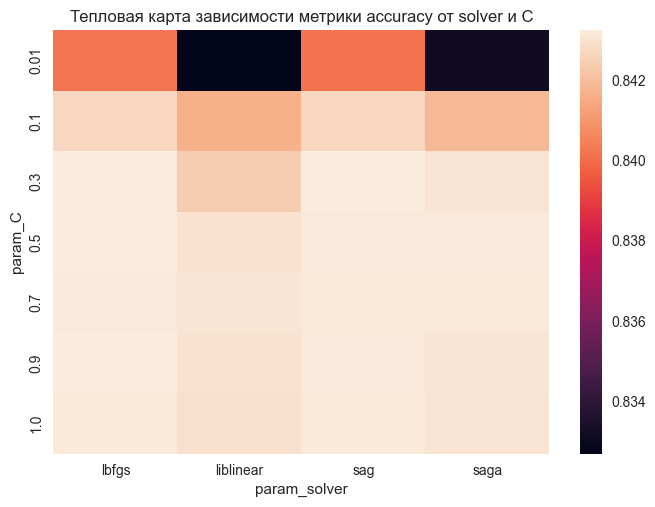

In [81]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0,5 и алгоритмы оптимизации lbfgs и sag работают лучше.

### <center> **RandomizedSearchCV**

Несмотря на то, что поиск по сетке — мощный метод для нахождения оптимального набора гиперпараметров, оценка всех возможных комбинаций требует множество времени и вычислительных ресурсов, а также кросс-валидации для обучения моделей.

В отличие от GridSearchCV, не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений. Количество комбинаций гиперпараметров задается n_iter.

С использованием класса RandomizedSearchCV из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии, дерева решений и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

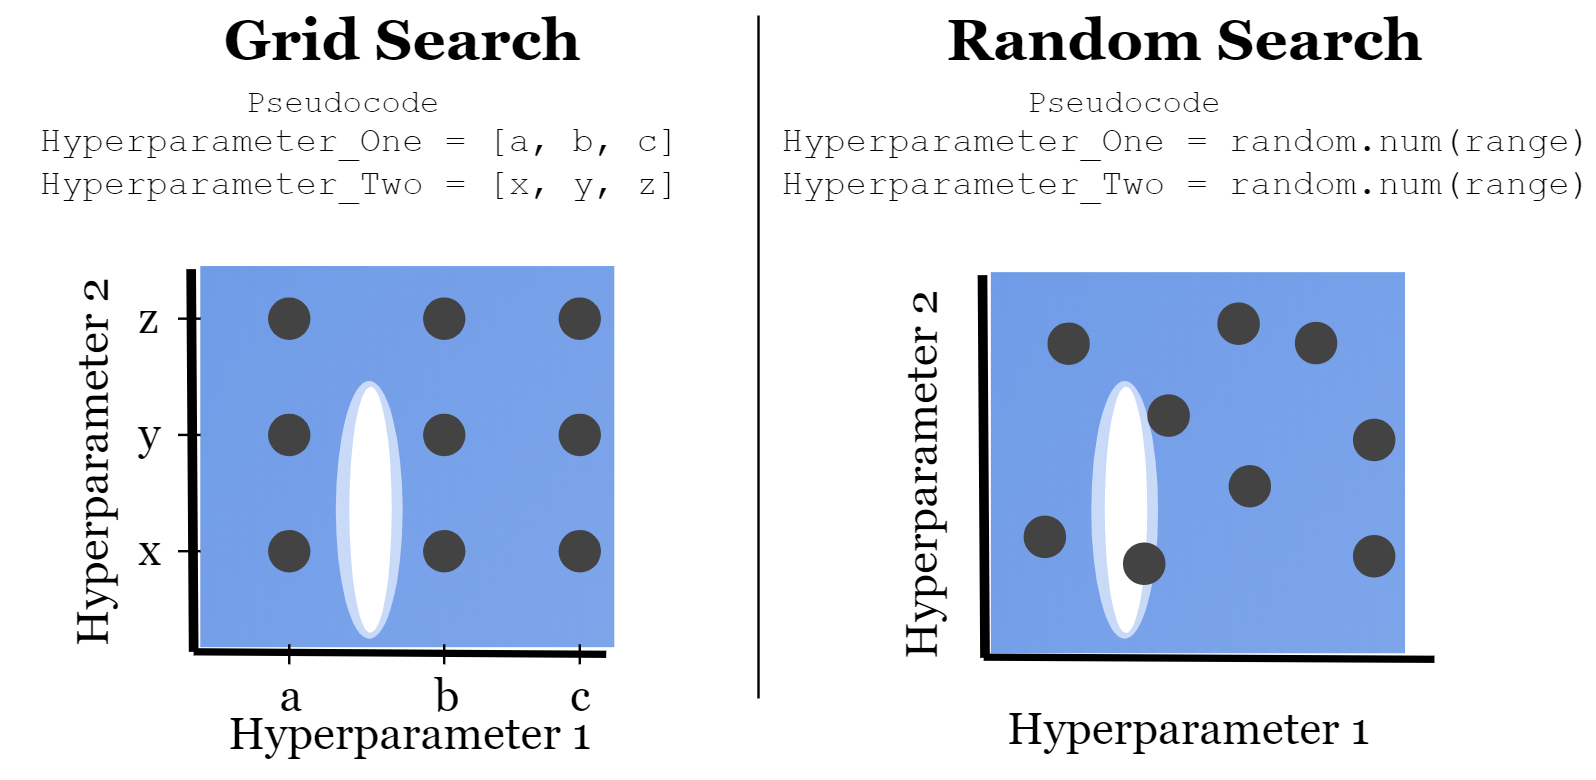

На этой картинке изображено принципиальное различие двух методов: 

* В GridSearchCV сетка задаётся вручную, перебираются различные значения гиперпараметров с каким-то шагом, в итоге получается что-то похожее на «красивую» сетку слева на картинке. Однако минимум функции (белое пятно) мы так и не обнаруживаем — а ведь он где-то рядом, возможно, просто между подобранными нами комбинациями.
* RandomizedSearchCV выбирает n (количество задаём сами) случайных точек/комбинаций из заданных нами последовательностей. Как следствие, мы можем перебирать не все возможные точки, а только часть из них, тем самым управляя скоростью работы перебора.

Основные параметры RandomizedSearchCV аналогичны GridSearchCV, за исключением наименований некоторых параметров и наличия параметра **n_iter**:

* **estimator** — алгоритм, который будем оптимизировать;
* **param_distributions** — cловарь с именами параметров (str) в качестве ключей и списками параметров в качестве значений, которые нужно попробовать.
**Примечание**. В ранних версиях sklearn данный параметр был обозначен как param_grid (как и в GridSearchCV).
* **scoring** — по умолчанию используется score-функция заданного алгоритма:
   * для классификации — sklearn.metrics.accuracy_score;

   * для регрессии — sklearn.metrics.r2_score.

Возможно выбрать любую другую в зависимости от условий задачи. Различные варианты смотрите [здесь](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

* **cv** — количество фолдов в кросс-валидации, по умолчанию используется 5.
* **n_jobs** — количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.
* **n_iter** — количество комбинаций на расчёт. От этого параметра напрямую зависит время оптимизации и качество модели.

In [82]:
from sklearn.model_selection import RandomizedSearchCV

# np.linspace(start(от), stop(до), num=50(количество), dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train_scaled, y_train) 
print(f'accuracy на тестовом наборе: {random_search.score(X_test_scaled, y_test):.2f}')
y_test_pred = random_search.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {random_search.best_params_}')

CPU times: total: 1.08 s
Wall time: 1min 13s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.89}


За 10 итераций метрику улучшить не удалось, но обратите внимание на время. Давайте зададим аналогичную сетку и проделаем тоже с помощью GridSearchCV и сравним:

In [83]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 10, 10, dtype=float))},
            
grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_2.fit(X_train_scaled, y_train) 
print(f'accuracy на тестовом наборе: {grid_search_2.score(X_test_scaled, y_test):.2f}')
y_test_pred = grid_search_2.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_2.best_params_}')

CPU times: total: 1.22 s
Wall time: 3min 5s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 3.34, 'penalty': 'l2', 'solver': 'lbfgs'}


На перебор всей сетки GridSearchCV понадобилось больше времени.

#### **Дерево решений**

Проделаем аналогичное для DecisionTreeClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [84]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print(f'Train: {metrics.f1_score(y_train, y_train_pred):.2f}')
y_test_pred = dt.predict(X_test_scaled)
print(f'Test: {metrics.f1_score(y_test, y_test_pred):.2f}')

Train: 1.00
Test: 0.62


Теперь зададим сетку гиперпараметров:  
*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;
*  'criterion' - критерий информативности

И посчитаем RandomizedSearchCV() и затем GridSearchCV()

In [85]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: total: 1.28 s
Wall time: 7.04 s
accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.66
Наилучшие значения гиперпараметров: {'min_samples_leaf': 34, 'max_depth': 15, 'criterion': 'gini'}


In [86]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 1min 17s
Wall time: 11min 25s
accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.65
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 39}


Метрику удалось улучшить  с помощью обоих методов, но RandomizedSearchCV потребовалось меньше времени;

#### **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [87]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.66


Теперь зададим сетку гиперпараметров:

* 'n_estimators' - количество деревьев в лесу, по умолчанию =100
* 'min_samples_leaf' - минимальное количество объектов в листе;
* 'max_depth': глубокое раскрытие дерева большое, не должно быть слишком, иначе будет переобучение;

И посчитаем RandomizedSearchCV() и потом GridSearchCV()

In [88]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 2.03 s
Wall time: 31.5 s
f1_score на обучающем наборе: 0.71
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 5, 'max_depth': 20}


In [89]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print(f'f1_score на обучающем наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'accuracy на тестовом наборе: {grid_search_forest.score(X_test_scaled, y_test):.2f}')
y_test_pred = grid_search_forest.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_forest.best_params_}')

CPU times: total: 2.33 s
Wall time: 1min 12s
f1_score на обучающем наборе: 0.71
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 110}


Метрику удалось еще больше улучшить с помощью обоих методов, но RandomizedSearchCV опять же потребовалось в два раза меньше времени;

Реализуем настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

* n_estimators = от 100 до 200 с шагом 30
* min_samples_leaf = [5, 7]
* max_depth = [10, 15, 20, 25]

Используйте RandomizedSearchCV с параметрами cv = 5, n_iter = 10

In [90]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print(f'Train: {metrics.f1_score(y_train, y_train_pred):.2f}')
y_test_pred = rf.predict(X_test_scaled)
print(f'Test: {metrics.f1_score(y_test, y_test_pred):.2f}')

Train: 1.00
Test: 0.66


In [91]:
param_distributions = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)   
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print(f'f1_score на обучающем наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'accuracy на тестовом наборе: {random_search_forest.score(X_test_scaled, y_test):.2f}')
y_test_pred = random_search_forest.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {random_search_forest.best_params_}')

CPU times: total: 3.47 s
Wall time: 34.5 s
f1_score на обучающем наборе: 0.70
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'n_estimators': 190, 'min_samples_leaf': 7, 'max_depth': 25}


Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:
* n_estimators = от 100 до 200 с шагом 30
* min_samples_leaf = [5, 7]
* max_depth = [10, 15, 20, 25]

Используйте GridSearchCV с параметрами cv = 5.

In [92]:
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print(f'f1_score на обучающем наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'accuracy на тестовом наборе: {grid_search_forest.score(X_test_scaled, y_test):.2f}')
y_test_pred = grid_search_forest.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_forest.best_params_}')

CPU times: total: 2.67 s
Wall time: 2min 1s
f1_score на обучающем наборе: 0.71
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}


#### **Вывод по базовой оптимизации:**
На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV над GridSearchCV.

## РЕКОМЕНДАЦИИ ПО НАСТРОЙКЕ ГИПЕРПАРАМЕТРОВ АНСАМБЛЕЙ НАД РЕШАЮЩИМИ ДЕРЕВЬЯМИ

### АЛГОРИТМ СЛУЧАЙНОГО ЛЕСА (RANDOMFOREST)

* n_estimators — число итераций (количество деревьев). Частично работает правило «чем больше, тем лучше», но иногда это не имеет особого смысла и сильно увеличивает затраты, поэтому стоит пробовать обучать сотни деревьев [100,200, 300, 400]. Если нет изменений, то оставить минимальное — 100.
* max_depth — максимальная глубина дерева. В случайном лесе строятся «сильные» деревья, каждое из которых даёт полноценный прогноз, поэтому глубина деревьем может быть достаточно большой. Стоит следить за переобучением.
* max_features — максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения;
* subsample — доля выборки, которая будет использоваться для обучения каждого алгоритма — дерева.

### АЛГОРИТМ ГРАДИЕНТНОГО БУСТИНГА (GRADIENTBOOSTING)

* **n_estimators** — число итераций (количество деревьев) : хотя ошибка на обучении монотонно стремится к нулю, ошибка на контроле, как правило, начинает увеличиваться после определенной итерации. Оптимальное число итераций можно выбирать, например, по отложенной выборке или с помощью кросс-валидации.
* **learning_rate** — темп обучения (0;1]:
На практике оказывается, что градиентный бустинг очень быстро строит композицию, ошибка которой на обучении выходит на асимптоту (достигает предела), после чего начинает настраиваться на шум и переобучаться. Параметр **learning_rate** контролирует, насколько сильно каждое дерево будет пытаться исправить ошибки предыдущих деревьев. Более высокая скорость обучения означает, что каждое дерево может внести более сильные корректировки. Как правило, **чем меньше темп обучения, тем лучше качество итоговой композиции**.

* **max_depth** — максимальная глубина дерева. Используется для борьбы с переобучением. Рекомендуется устанавливать не более 5.
* **max_features** — максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения.
* **subsample** — доля выборки, которая будет использоваться для обучения каждого алгоритма. Это ещё один способ улучшения качества градиентного бустинга. Таким образом вносится рандомизация в процесс обучения базовых алгоритмов, что снижает уровень шума в обучении, а также повышает эффективность вычислений. 
**Рекомендация**. Берите подвыборки, размер которых вдвое меньше исходной выборки.

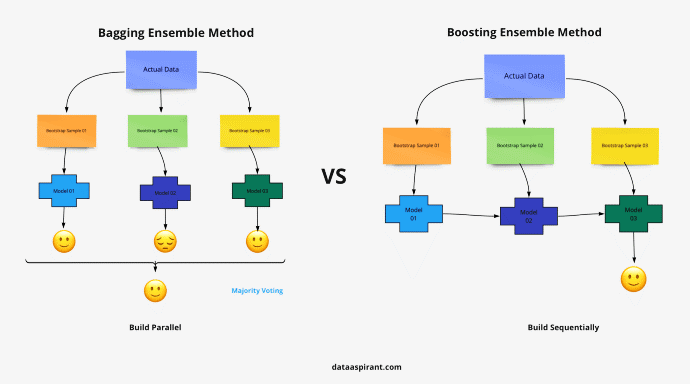

Главное отличие техник Bagging и Boosting состоит в параллельном и последовательном построении деревьев соответственно.

Основные параметры градиентного бустинга деревьев — это количество деревьев (**n_estimators**) и скорость обучения (**learning_rate**), контролирующие степень вклада каждого дерева в устранение ошибок предыдущих деревьев. Эти два параметра тесно взаимосвязаны, поскольку более низкое значение **learning_rate** означает, что для построения модели аналогичной сложности необходимо большее количество деревьев.

В отличие от случайного леса, в котором более высокое значение **n_estimators** всегда дает лучшее качество, увеличение значения **n_estimators** в градиентном бустинге даёт более сложную модель, что может привести к переобучению. При всём этом случайный лес, в отличие от градиентного бустинга, использует глубокие деревья, способные сформировать полноценный прогноз. 

Общепринятая практика для бустинга — подгонять **n_estimators** в зависимости от бюджета времени и памяти, а затем подбирать различные значения **learning_rate**.

Подробнее о градиентном бустинге можно почитать [по ссылке](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html). 

Методов RandomizedSearchCV и GridSearchCV вполне достаточно для решения большинства базовых задач. Однако существуют и более эффективные методы.

## 3. Продвинутая оптимизация.

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации, поэтому в идеале мы хотим делать это самым эффективным образом. 

Один из способов — это выбор следующей комбинации гиперпараметров на основе прошлых результатов. 
**Байесовская оптимизация** отличается от случайного поиска или поиска по сетке тем, что делает именно это: вместо того, чтобы просто выбирать комбинации из сетки, не имеющей информации о прошлых оценках, байесовские методы учитывают предыдущие результаты, чтобы попробовать более многообещающие комбинации значений. Это позволяет во многих случаях найти лучшие значения гиперпараметров модели за меньшее количество времени.
Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей машинного обучения.

Существует несколько разных алгоритмов для этого типа оптимизации, но особенно используемым является **Tree-Structured Parzen Estimators (TPE)**.

## <center> TREE-STRUCTURED PARZEN ESTIMATORS (TPE)

1. На каждой итерации алгоритм TPE учитывает информацию о прошлых опробованных комбинациях гиперпараметров и только потом принимает решение, какой набор следует попробовать дальше. 

   * Чтобы приступить к использованию TPE, необходимо выполнить несколько итераций с помощью случайного поиска. 

2. На следующем шаге происходит разделение собранных наборов на две группы:

* в первую группу входят наборы, дающие наилучшие результаты после оценки;
* во вторую — все остальные.

На изображении ниже: первая группа — красные точки находятся в области минимума целевой функции; вторая группа — синие точки, все остальные.

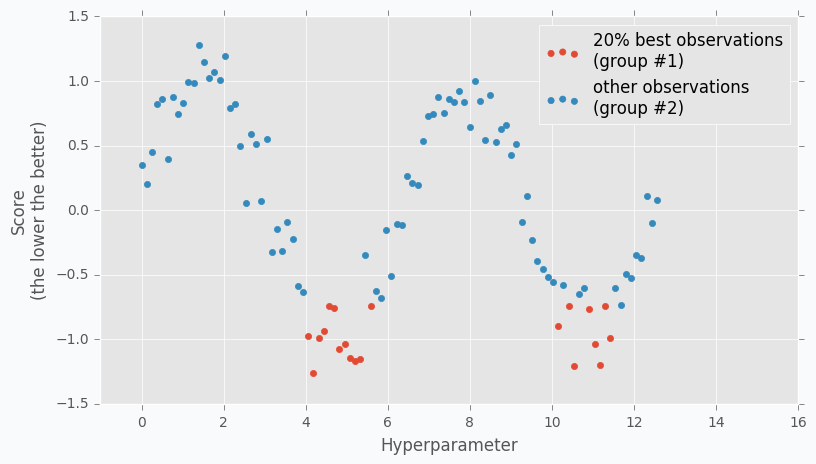

Основная цель алгоритма — найти набор гиперпараметров, который с большей вероятностью будет в первой группе и с меньшей вероятностью во второй группе. Таким образом, для принятия следующего решения используется целое распределение наилучших комбинаций — **красные точки** на графике.

3. Далее TPE моделирует вероятности правдоподобия для каждой из групп, используя формулу Байеса:

$p(y|x) = {{p(x|y) \times p(y)} \over p(x)}$

где $x$ — гиперпараметры, $y$ — соответствующая оценка качества модели.

Подробнее про теорему Байеса можно прочитать [по ссылке](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%B0)

4. Затем, используя вероятность правдоподобия из первой группы, отбирается набор комбинаций, которые с большей вероятностью попадут в первую группу и с меньшей вероятностью — во вторую. 

Определяем ожидаемое улучшение для каждой комбинации:

$E[I(x)] = {l(x) \over g(x)}$

где $E$ — это знак математического ожидания.

5. Шаги 2-4  будет выполняться до тех пор, пока не будет достигнуто максимальное количество итераций. 

В итоге мы найдём наилучшую комбинацию гиперпараметров.

Более подробное описание алгоритма с математическими выкладками вы можете найти [здесь](https://ml-handbook.ru/chapters/hyperparameters_tuning/intro#tree-structured-parzen-estimator-tpe).

### <center> Hyperopt

**Hyperopt** — это библиотека Python с открытым исходным кодом на основе байесовской оптимизации, в которой реализован алгоритм **Tree-Structured Parzen Estimators (TPE)**.

Три шага для использования Hyperopt:

1. Задание пространства поиска гиперпараметров. 

Объявляем список гиперпараметров, тип распределения и его границы.

Основные (наиболее часто используемые) типы:

* hp.choice(label, options) — равновероятный выбор из массива. Массив (список/кортеж) вы задаёте сами, в списке могут быть как числа, так и строки (категории), но, как правило, данный метод используется для оптимизации категориального гиперпараметра (например, тип регуляризации в линейной регрессии или критерий информативности в деревьях);
* hp.randint(label, upper) — возвращает случайное целое число из диапазона [0, upper];
* hp.uniform(label, low, high) — создаёт равномерное непрерывное распределение и возвращает случайное число (не обязательно целое) из диапазона [low, high];
* hp.normal(label, mu, sigma) — создаёт нормальное непрерывное распределение с параметрами mu и sigma и возвращает случайное число из этого распределения;
* hp.lognormal(label, mu, sigma) — создаёт логнормальное непрерывное распределение с параметрами mu и sigma и возвращает случайное число из этого распределения.

2. Задание целевой функции. 

Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики. Можем минимизировать/максимизировать значение метрики.

3. Задание алгоритма поиска:

* Random Search.
* Tree of Parzen Estimators (TPE).

Полезные ссылки: 

* [Hyperopt: A Python Library for Optimizing the Hyperparameters of Machine Learning Algorithms](https://lms-cdn.skillfactory.ru/assets/courseware/v1/32710b2c3069452833036ea0e4da10fe/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/bergstra_hyperopt.pdf)
* [Hyperopt на GitHub](https://github.com/hyperopt/hyperopt/)
* [Байесовский ниндзя (Хабр)](https://habr.com/ru/post/494242/)

In [93]:
# Устанавливаем библиотеку
! pip install hyperopt
# или
#!conda install -c conda-forge hyperopt

Defaulting to user installation because normal site-packages is not writeable


In [94]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print(f'Версия Hyperopt : {hyperopt.__version__}')

Версия Hyperopt : 0.2.7


**Примечание**. Если на этапе подбора гиперпараметров у вас возникла ошибка, не переживайте, это из-за разницы версий библиотеки.

* Для версии **hyperopt==0.2.5** все отработает верно.
* Для версии **hyperopt==0.2.7** будет ошибка из-за изменений в определении параметра rstate, теперь вместо **rstate=np.random.RandomState(random_state)**, необходимо использовать другой генератор случайных чисел: **rstate=np.random.default_rng(random_state)**.

*версия библиотеки никак не влияет на подбор параметров, но хорошим тоном считается своевременное обновление модулей, хотя в действительности это часто влечет возникновение ряда других ошибок из-за нарушений зависимостей, поэтому осуществляется по необходимости*.

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [95]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [96]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [97]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print(f'Наилучшие значения гиперпараметров {best}')

100%|██████████| 20/20 [00:59<00:00,  2.99s/trial, best loss: -0.7548124717577949]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 59.2 s
Wall time: 59.8 s


In [98]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print(f'f1_score на обучающем наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'accuracy на тестовом наборе: {model.score(X_test_scaled, y_test):.2f}')
y_test_pred = model.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на обучающем наборе: 0.75
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67


Мы можем продолжить поиск гиперпараметров, чтобы получить лучшие результаты.

Для байесовских оптимизаторов это возможно, так как они ориентируются на прошлые результаты: предыдущие входные данные для целевой функции и результирующие потери.

Hyperopt продолжит поиск с того места, где он остановился, если мы передадим ему объект Trials, который уже содержит информацию о предыдущих запусках.

Всегда сохраняйте свои предыдущие результаты.

In [99]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print(f'Наилучшие значения гиперпараметров {best}')

100%|██████████| 23/23 [00:08<00:00,  2.78s/trial, best loss: -0.7784334763948497]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 2.0, 'n_estimators': 101.0}


Видим, что Hyperot смог улучшить нашу метрику, причем за меньшее время.

По графикам видно, что лучшая точность достигается именно в best_params. Но заметьте, что метрика отрицательная, так как нам необходимо максимизировать нашу метрику, в то время как,  hyperopt может только минимизировать.

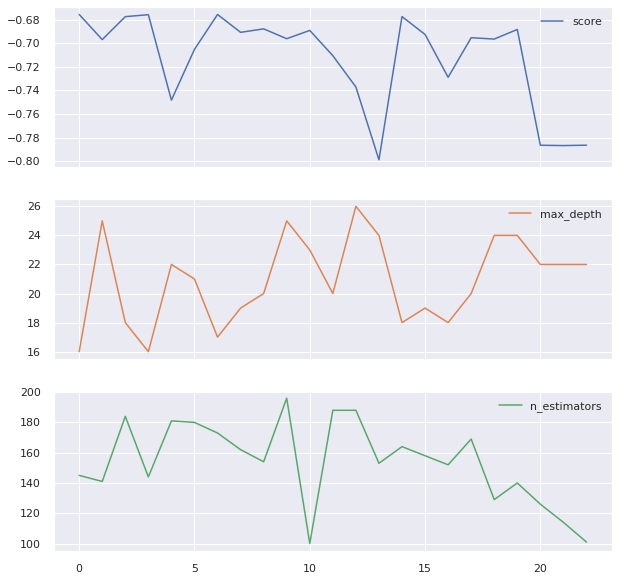

Реализуем настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

* n_estimators = от 100 до 300 включительно с шагом 10
* min_samples_leaf = от 3 до 7 с шагом 1
* max_depth = от 15 до 40 с шагом 1

Используем Hyperopt с параметрами max_evals = 20.

In [100]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [101]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [102]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print(f'Наилучшие значения гиперпараметров {best}')

100%|██████████| 20/20 [01:19<00:00,  3.95s/trial, best loss: -0.7639828998931244]
Наилучшие значения гиперпараметров {'max_depth': 30.0, 'min_samples_leaf': 3.0, 'n_estimators': 130.0}
CPU times: total: 1min 18s
Wall time: 1min 19s


In [104]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print(f'f1_score на обучающем наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'accuracy на тестовом наборе: {model.score(X_test_scaled, y_test):.2f}')
y_test_pred = model.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на обучающем наборе: 0.76
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


In [105]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print(f'Наилучшие значения гиперпараметров {best}')

100%|██████████| 23/23 [00:12<00:00,  4.03s/trial, best loss: -0.7667794196190137]
Наилучшие значения гиперпараметров {'max_depth': 32.0, 'min_samples_leaf': 3.0, 'n_estimators': 220.0}


## <center> Optuna

Optuna - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

Три шага для использования Optuna: 

1. Задание пространства поиска гиперпараметров.

Основные функции:

* *suggest_categorical(name, choices)* — для категориальных гиперпараметров;
* *suggest_int(name,low,high,step=1,log=False)* — для целочисленных гиперпараметров;
* *suggest_float(name,low,high,step=None,log=False)* — для непрерывных гиперпараметров;
* *suggest_uniform(name,low,high)* — для целочисленных и непрерывных гиперпараметров.

С помощью необязательных аргументов step и log можно дискретизировать или взять логарифм целочисленных и непрерывных параметров.

2. Задание целевой функции. 

Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики, можем минимизировать/максимизировать значение метрики. На данном этапе будет обучена модель только на одной комбинации гиперпараметров.

3. Создание объекта исследования **create study**. 

По умолчанию используется алгоритм поиска TPE (есть и другие варианты) и вызов метода optimize(), в который передаётся целевая функция, созданная на первом шаге. Выполняется заданное n_trials раз, подставляются различные комбинации гиперпараметров.

[Официальный сайт Optuna](https://optuna.org/)

In [106]:
# Устанавливаем библиотеку
! pip install optuna
# или
#!conda install -c conda-forge optuna

Defaulting to user installation because normal site-packages is not writeable


In [107]:
import optuna

print(f'Версия Optuna: {optuna.__version__}')

Версия Optuna: 3.2.0


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [108]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  
  

In [109]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-07-11 17:18:00,829] A new study created in memory with name: RandomForestClassifier
[I 2023-07-11 17:18:04,683] Trial 0 finished with value: 0.7173992008717762 and parameters: {'n_estimators': 188, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7173992008717762.
[I 2023-07-11 17:18:08,471] Trial 1 finished with value: 0.7549285585096763 and parameters: {'n_estimators': 180, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7549285585096763.
[I 2023-07-11 17:18:11,205] Trial 2 finished with value: 0.6531238022230741 and parameters: {'n_estimators': 171, 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7549285585096763.
[I 2023-07-11 17:18:15,537] Trial 3 finished with value: 0.8140641522735285 and parameters: {'n_estimators': 189, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8140641522735285.
[I 2023-07-11 17:18:19,343] Trial 4 finished with value: 0.7255577725376384 and parameters: {'n_

CPU times: total: 57.1 s
Wall time: 57.7 s


In [110]:
# выводим результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value:.2f}')

Наилучшие значения гиперпараметров {'n_estimators': 101, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


In [111]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print(f'accuracy на тестовом наборе: {model.score(X_test_scaled, y_test):.2f}')
y_test_pred = model.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


In [112]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2023-07-11 17:19:06,029] Trial 20 finished with value: 0.7942745376955903 and parameters: {'n_estimators': 200, 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.8213440813107858.
[I 2023-07-11 17:19:08,389] Trial 21 finished with value: 0.8199193406978782 and parameters: {'n_estimators': 100, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.8213440813107858.
[I 2023-07-11 17:19:10,899] Trial 22 finished with value: 0.7590888789638232 and parameters: {'n_estimators': 110, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.8213440813107858.
[I 2023-07-11 17:19:13,414] Trial 23 finished with value: 0.8214473453653409 and parameters: {'n_estimators': 110, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.8214473453653409.
[I 2023-07-11 17:19:16,147] Trial 24 finished with value: 0.7634610233056524 and parameters: {'n_estimators': 126, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 23 with va

CPU times: total: 28.3 s
Wall time: 28.6 s


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [113]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [114]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [115]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [116]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Точки с синим фоном это и есть лучшии комбинации n_estimator, max_depth.
















Реализуем настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

* n_estimators = от 100 до 300 включительно с шагом 10
* min_samples_leaf = от 3 до 7 с шагом 1
* max_depth = от 15 до 40 с шагом 1
Используем Optuna с параметрами n_trails = 20.

In [117]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [118]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-07-11 17:19:31,035] A new study created in memory with name: RandomForestClassifier
[I 2023-07-11 17:19:33,017] Trial 0 finished with value: 0.702919708029197 and parameters: {'n_estimators': 100, 'max_depth': 25, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.702919708029197.
[I 2023-07-11 17:19:36,431] Trial 1 finished with value: 0.6840638930163447 and parameters: {'n_estimators': 170, 'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.702919708029197.
[I 2023-07-11 17:19:39,682] Trial 2 finished with value: 0.7022173355323438 and parameters: {'n_estimators': 150, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.702919708029197.
[I 2023-07-11 17:19:43,272] Trial 3 finished with value: 0.7123885755866837 and parameters: {'n_estimators': 150, 'max_depth': 39, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.7123885755866837.
[I 2023-07-11 17:19:47,049] Trial 4 finished with value: 0.758731576596695 and parameters: {'n_estim

CPU times: total: 1min 13s
Wall time: 1min 14s


In [119]:
# выводим результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value:.2f}')

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.77


In [120]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


## ПЛЮСЫ И МИНУСЫ РАССМОТРЕННЫХ ФРЕЙМВОРКОВ И БИБЛИОТЕК

**GridSearchCV**	
✔️ Простой в использовании, идеален для небольшой сетки гиперпараметров

✔️ Встроенная кросс-валидация

✔️ Включает построение итоговой модели на всей обучающей выборке 

⛔️ Перебирает просто все комбинации заданной сетки гиперпараметров 

⛔️  Требует много времени и вычислительных ресурсов

**RandomizedSearchCV**	

✔️ Эффективнее и экономичнее gridsearchcv

✔️ Можно задать количество рассматриваемых комбинаций

⛔️ Просто выбирает рандомные комбинации гиперпараметров без учёта результатов прошлых итераций

**Hyperopt**	

✔️ Быстрее и эффективнее, чем классические методы перебора (GSCV и RSCV)

✔️ Учитывает результаты прошлых итераций — байесовский оптимизатор

✔️ Можно отслеживать дополнительную информацию на каждом шаге с помощью класса Trials

✔️ Возможность построения условного пространства поиска гиперпараметров и даже моделей

⛔️ Старая документация, плохо с поддержкой и обновлением 

⛔️ Способен только минимизировать

⛔️ Непростой синтаксис описания пространства гиперпараметров (особенно с использованием условных реализаций)

**Optuna**	

✔️ Один из самых быстрых и эффективных

✔️ Специально разработан для оптимизации гиперпараметров 

✔️ Простой в использовании

✔️ Относительно новый фреймворк с хорошей документацией 

✔️ Учитывает результаты прошлых итераций — байесовский оптимизатор 

✔️ Встроенная визуализация результатов

✔️ Возможность явно задавать максимизацию или минимизацию функции качества

⛔️ Удаление «плохих» точек пространства из рассмотрения

⛔️ Не стоит полностью полагаться: важно с умом определять пространство поиска, что может значительно сократить время расчётов.